# Documentation for Standard Keras Neural Network
- ROC AUC for different masses
- learning curve
- validation curves

In [0]:
region='ge6jge4b'
invertTestTrain=False

# Standard imports

In [6]:
! rm -rf HplusML pandas_INC_ge6jge4b.h5
! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6jge4b.h5

--2019-03-21 08:50:01--  https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6jge4b.h5
Resolving jglatzer.web.cern.ch (jglatzer.web.cern.ch)... 188.184.64.89, 2001:1458:201:a4::100:53
Connecting to jglatzer.web.cern.ch (jglatzer.web.cern.ch)|188.184.64.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51165780 (49M) [text/plain]
Saving to: ‘pandas_INC_ge6jge4b.h5’

pandas_INC_ge6jge4b 100%[===================>]  48.79M  10.7MB/s    in 5.9s    

2019-03-21 08:50:08 (8.22 MB/s) - ‘pandas_INC_ge6jge4b.h5’ saved [51165780/51165780]



In [7]:
! git clone https://github.com/JulianGlatzer/HplusML
import sys
sys.path.append("HplusML")
#!cd HplusML; git pull origin

Cloning into 'HplusML'...
remote: Enumerating objects: 363, done.
remote: Total 363 (delta 0), reused 0 (delta 0), pack-reused 363
Receiving objects: 100% (363/363), 17.72 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpMLUtils
import HpKerasUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame
from importlib import reload
#reload(HpKerasUtils)

In [9]:
df_mc=pd.read_hdf('pandas_INC_'+region+'.h5', 'INC_'+region)
df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc","Hp800"] else False)]
df_mc['process'].unique()

array(['ttlight', 'ttc', 'ttb', 'Hp800'], dtype=object)

# Prepare data for H+ classification

split into test and training data

In [0]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc) 

In [0]:
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=800)
if invertTestTrain:
  X_tmp=X_train
  y_tmp=y_train
  w_tmp=w_train
  X_train=X_test
  y_train=y_test
  w_train=w_test
  X_test=X_tmp
  y_test=y_tmp
  w_test=w_tmp
summarizeFitData(X_train, y_train, w=w_train)

sb=MultiSBWeightsScaler(backgroundclass=0)
sb.fit(X_train,y_train, sample_weight=w_train)
X_train=sb.transform(X_train,y_train, sample_weight=w_train)
X_test=sb.transform(X_test,y_test, sample_weight=w_test)
#w_train.groupby(y_train).sum()
summarizeFitData(X_train, y_train, w=w_train)

wss=WeightedStandardScaler()
wss.fit(X_train,sample_weight=w_train)
X_train=wss.transform(X_train)
X_test=wss.transform(X_test)
#X_eval=wss.transform(X_eval)
print("Summarizing train data after weighted standard scaler")
summarizeFitData(X_train, y_train, w=w_train)
print("Summarizing test data after weighted standard scaler")
summarizeFitData(X_test, y_test, w=w_test)

X.shape= (23068, 14) y.shape= (23068,)w.shape= (23068,)
columns= Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all'],
      dtype='object')
categories= [0, 1]

sum of weights per category
       all 1464.0889689061605
         0 1457.1067579711676
         1 6.982210934992669


average
  variable/class       all         0         1
           nJets      6.99      6.99      7.43
       nBTags_70      4.06      4.06       4.1
         pT_jet1  1.77e+05  1.77e+05  2.96e+05
    Mbb_MindR_70  7.76e+04  7.73e+04  1.33e+05
         pT_jet5  5.06e+04  5.05e+04  6.68e+04
          H1_all     0.226     0.227     0.182
     dRbb_avg_70      2.28      2.28      2.42
dRlepbb_MindR_70      2.31      2.31      2.17
    Muu_MindR_70  1.05e+05  1.05e+05  1.06e+05
         HT_jets  5.69e+05  5.68e+05  8.62e+05
    Mbb_MaxPt_70  1.66e+05  1.66

define a function to build our sequential Keras model (L2 regularisation and dropout are optional)

In [0]:
model=HpKerasUtils.HpFeedForwardModel(configuration=[64],dropout=None, verbose=True, input_dim=14)
roc_test, roc_train=model.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values),)

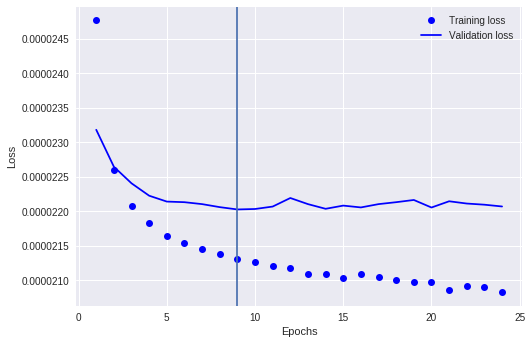

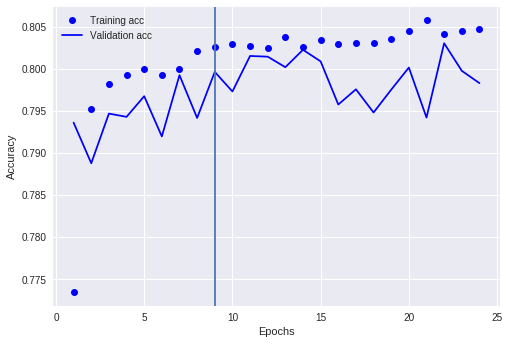

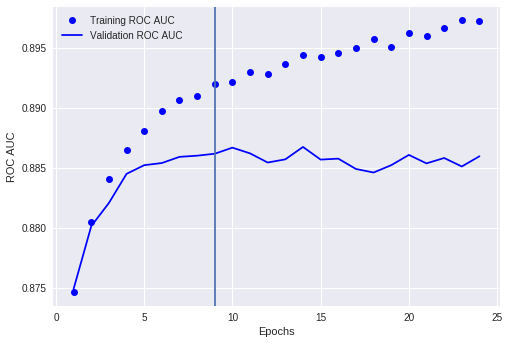

In [0]:
HpKerasUtils.HpFeedForwardModel.plotTrainingValidation(model)

In [0]:
nodes=[4,8,16,32,64]
#nodes=[4,8,16]

def addLayer(inputconfs):
  confs=[]
  if len(inputconfs)==0:
    return [[size] for size in nodes]
  else:
    for conf in inputconfs:
      for size in nodes:
        if size <= conf[-1]:
          confs.append(conf+[size])
  return confs

def trainAllConfigurations(nlayers, dropout=None):
  models={}
  results={}
  configurations=[]
  for layer in range(nlayers):
    configurations=addLayer(configurations)
  print(len(configurations), configurations)
  for configuration in configurations:
    print(configuration)
    model=HpKerasUtils.HpFeedForwardModel(configuration=configuration,dropout=dropout, verbose=False, input_dim=14)
    result=model.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)
    models[str(configuration)]=model
    results[str(configuration)]=result
  return models, results

In [0]:
models1nodropout,results1nodropout=trainAllConfigurations(1)

In [0]:
models2nodropout,results2nodropout=trainAllConfigurations(2)

In [0]:
models2dropout01,results2dropout01=trainAllConfigurations(2, dropout=0.1)

In [0]:
models2dropout02,results2dropout02=trainAllConfigurations(2, dropout=0.2)

In [0]:
for conf in results1nodropout:
  print("{:>10}".format(conf), "{:.4f} {:.4f}".format(results1nodropout[conf][0],results1nodropout[conf][1]))
for conf in results2nodropout:
  print("{:>10}".format(conf), "{:.4f} {:.4f}".format(results2nodropout[conf][0],results2nodropout[conf][1]),
                               "{:.4f} {:.4f}".format(results2dropout01[conf][0],results2dropout01[conf][1]),
                               "{:.4f} {:.4f}".format(results2dropout02[conf][0],results2dropout02[conf][1]))

       [4] 0.8857 0.8872
       [8] 0.8862 0.8893
      [16] 0.8866 0.8903
      [32] 0.8862 0.8892
      [64] 0.8867 0.8918
    [4, 4] 0.8837 0.8864 0.8849 0.8863 0.8750 0.8751
    [8, 4] 0.8854 0.8901 0.8827 0.8858 0.8787 0.8800
    [8, 8] 0.8847 0.8890 0.8848 0.8907 0.8840 0.8864
   [16, 4] 0.8856 0.8930 0.8867 0.8897 0.8844 0.8866
   [16, 8] 0.8854 0.8938 0.8870 0.8921 0.8859 0.8905
  [16, 16] 0.8857 0.8926 0.8862 0.8909 0.8877 0.8914
   [32, 4] 0.8850 0.8953 0.8868 0.8940 0.8864 0.8921
   [32, 8] 0.8856 0.8945 0.8867 0.8949 0.8864 0.8900
  [32, 16] 0.8851 0.8906 0.8878 0.8946 0.8863 0.8903
  [32, 32] 0.8855 0.8951 0.8872 0.8932 0.8872 0.8947
   [64, 4] 0.8863 0.8968 0.8874 0.8944 0.8873 0.8948
   [64, 8] 0.8853 0.8954 0.8869 0.8942 0.8876 0.8956
  [64, 16] 0.8856 0.8944 0.8873 0.8976 0.8875 0.8933
  [64, 32] 0.8865 0.8956 0.8875 0.8939 0.8877 0.8934
  [64, 64] 0.8861 0.8910 0.8880 0.8913 0.8881 0.8977


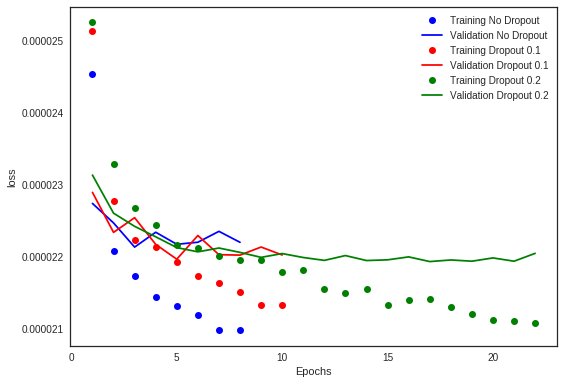

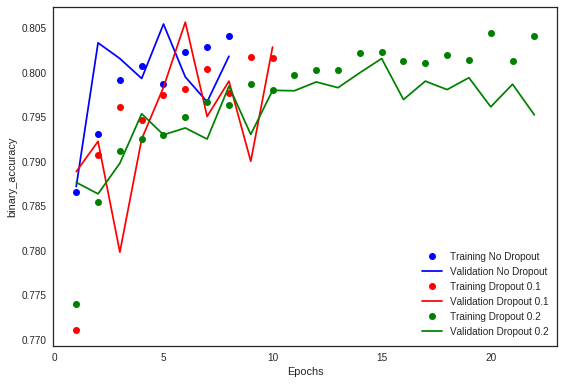

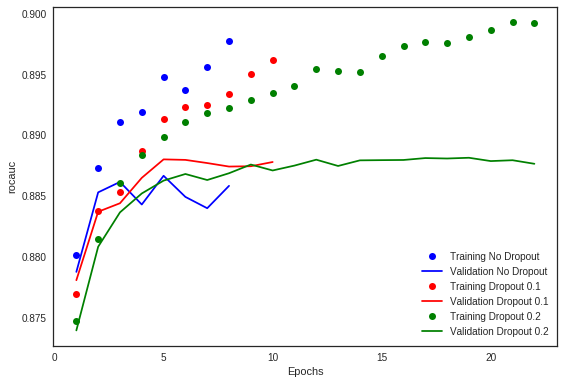

In [0]:
def plotByDropout(configuration=[64,64], variable="loss", validationvariable="val_loss"):
  if variable=="rocauc":
    index=-1
    for i,cb in enumerate(models2nodropout[str(configuration)].callbacks):
      if hasattr(cb, 'roc') and hasattr(cb, 'roc_val'):
        index=i
    
    loss_values_nodropout=models2nodropout[str(configuration)].callbacks[i].roc
    val_loss_values_nodropout=models2nodropout[str(configuration)].callbacks[i].roc_val
    loss_values_dropout01=models2dropout01[str(configuration)].callbacks[i].roc
    val_loss_values_dropout01=models2dropout01[str(configuration)].callbacks[i].roc_val
    loss_values_dropout02=models2dropout02[str(configuration)].callbacks[i].roc
    val_loss_values_dropout02=models2dropout02[str(configuration)].callbacks[i].roc_val

  else:
    loss_values_nodropout=models2nodropout[str(configuration)].history.history[variable]
    val_loss_values_nodropout=models2nodropout[str(configuration)].history.history[validationvariable]
    loss_values_dropout01=models2dropout01[str(configuration)].history.history[variable]
    val_loss_values_dropout01=models2dropout01[str(configuration)].history.history[validationvariable]
    loss_values_dropout02=models2dropout02[str(configuration)].history.history[variable]
    val_loss_values_dropout02=models2dropout02[str(configuration)].history.history[validationvariable]

  epochs_nodropout=range(1,len(loss_values_nodropout)+1)
  epochs_dropout01=range(1,len(loss_values_dropout01)+1)
  epochs_dropout02=range(1,len(loss_values_dropout02)+1)
  
  plt.figure()
  plt.plot(epochs_nodropout, loss_values_nodropout, "bo",label="Training No Dropout")
  plt.plot(epochs_nodropout, val_loss_values_nodropout, "b",label="Validation No Dropout")
  plt.plot(epochs_dropout01, loss_values_dropout01, "ro",label="Training Dropout 0.1")
  plt.plot(epochs_dropout01, val_loss_values_dropout01, "r",label="Validation Dropout 0.1")
  plt.plot(epochs_dropout02, loss_values_dropout02, "go",label="Training Dropout 0.2")
  plt.plot(epochs_dropout02, val_loss_values_dropout02, "g",label="Validation Dropout 0.2")
  plt.xlabel("Epochs")
  plt.ylabel(variable)

  plt.tight_layout()
  plt.legend()
  
 
plotByDropout()
plotByDropout(variable="binary_accuracy", validationvariable="val_binary_accuracy")
plotByDropout(variable="rocauc")

**Dropout is certainly a good thing to have**, not so much because of performance, but to remove the unstable behaviour

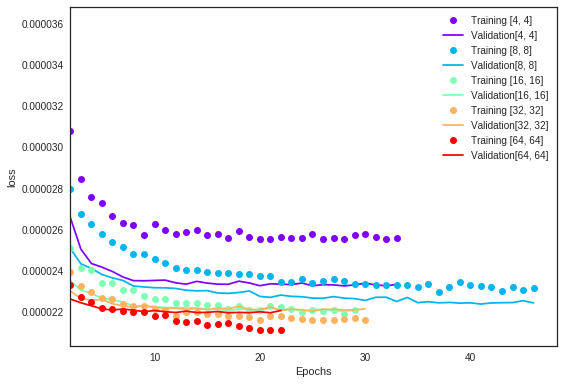

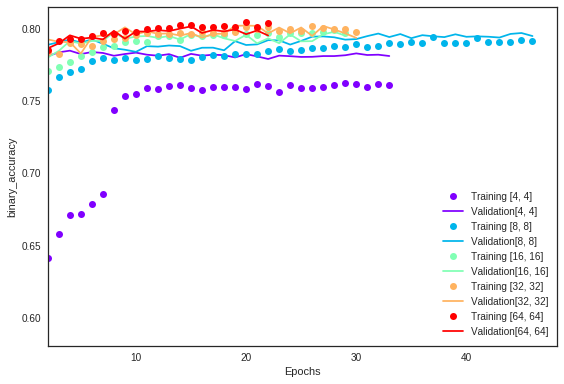

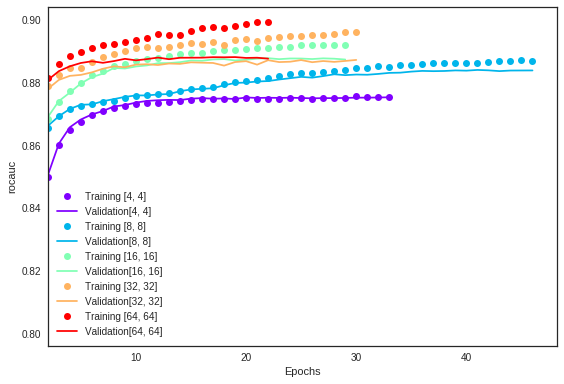

In [0]:
def plotByConfiguration(configurations=[[4,4],[8,8],[16,16],[32,32],[64,64]], variable="loss", validationvariable="val_loss"):
  color=iter(plt.cm.rainbow(np.linspace(0,1,len(configurations))))
  
  if variable=="rocauc":
    index=-1
    for i,cb in enumerate(models2nodropout[str(configurations[0])].callbacks):
      if hasattr(cb, 'roc') and hasattr(cb, 'roc_val'):
        index=i
  
  plt.figure()
  for configuration in configurations:

    if variable=="rocauc":
      loss_values=models2dropout02[str(configuration)].callbacks[i].roc
      val_loss_values=models2dropout02[str(configuration)].callbacks[i].roc_val
    else:
      loss_values=models2dropout02[str(configuration)].history.history[variable]
      val_loss_values=models2dropout02[str(configuration)].history.history[validationvariable]
    epochs=range(1,len(loss_values)+1)
    c=next(color)
    plt.plot(epochs, loss_values,"o", color=c,label="Training "+str(configuration))
    plt.plot(epochs, val_loss_values, color=c, label="Validation"+str(configuration))
    
  plt.xlim(left=2)
  plt.xlabel("Epochs")
  plt.ylabel(variable)
  plt.tight_layout()
  plt.legend()
  
 
plotByConfiguration()
plotByConfiguration(variable="binary_accuracy", validationvariable="val_binary_accuracy")
plotByConfiguration(variable="rocauc")

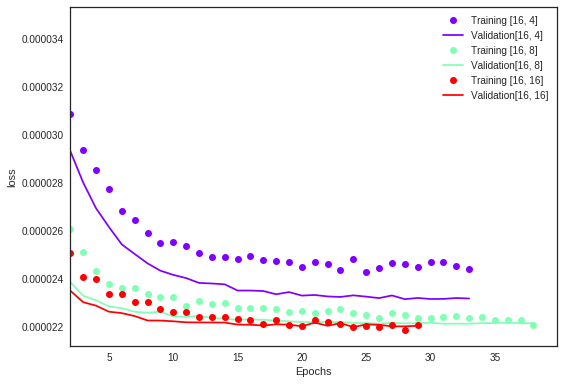

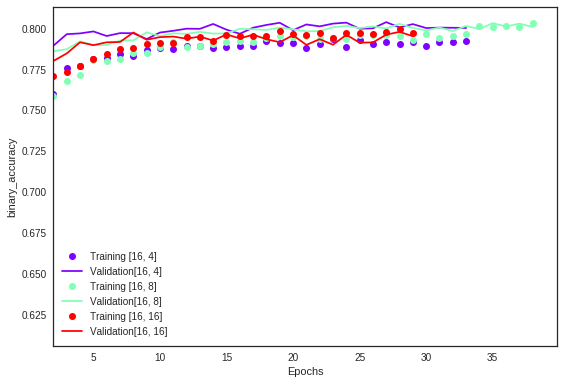

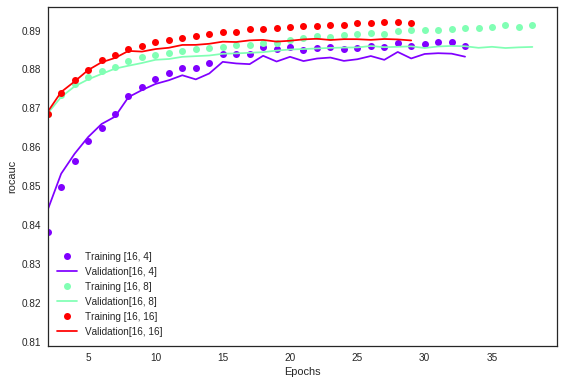

In [0]:
configurations=[[16,4],[16,8],[16,16]]
plotByConfiguration(configurations)
plotByConfiguration(configurations, variable="binary_accuracy", validationvariable="val_binary_accuracy")
plotByConfiguration(configurations, variable="rocauc")

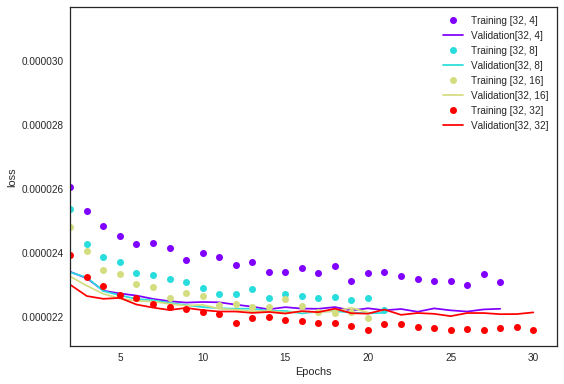

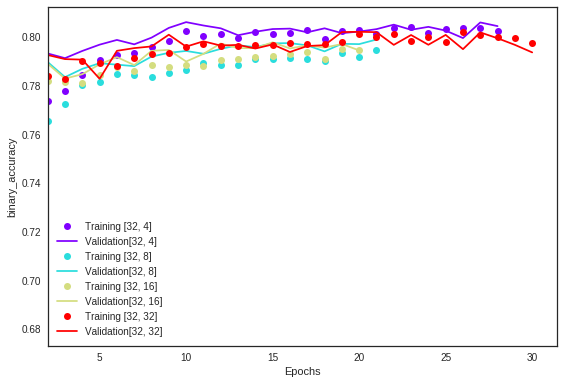

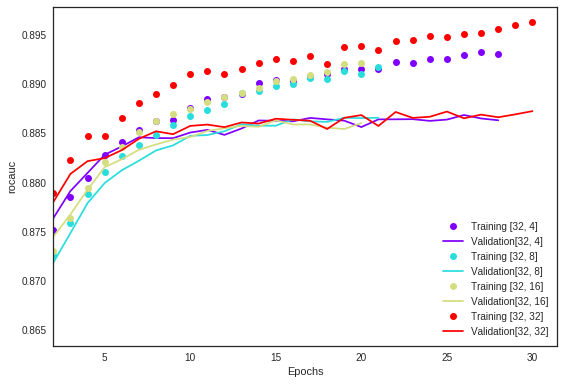

In [0]:
configurations=[[32,4],[32,8],[32,16],[32,32]]
plotByConfiguration(configurations)
plotByConfiguration(configurations, variable="binary_accuracy", validationvariable="val_binary_accuracy")
plotByConfiguration(configurations, variable="rocauc")

# Compare the results to the standard BDT

In [0]:
import HpAlgorithms
clf=HpAlgorithms.getGradientBDTClassifier()
Xbdt_train, Xbdt_test, Xbdt_eval, ybdt_train, ybdt_test,ybdt_eval, wbdt_train, wbdt_test, wbdt_eval=htf.prepare(hpmass=800)
if invertTestTrain:
  Xbdt_tmp=X_train
  ybdt_tmp=y_train
  wvdt_tmp=w_train
  Xvdt_train=X_test
  ybdt_train=y_test
  wbdt_train=w_test
  Xbdt_test=X_tmp
  ybdt_test=y_tmp
  wbdt_test=w_tmp
#summarizeFitData(Xbdt_train, ybdt_train, w=wbdt_train)
sb=MultiSBWeightsScaler(backgroundclass=0)
sb.fit(Xbdt_train,ybdt_train, sample_weight=wbdt_train)
Xbdt_train=sb.transform(Xbdt_train,ybdt_train, sample_weight=wbdt_train)
Xbdt_test=sb.transform(Xbdt_test,ybdt_test, sample_weight=wbdt_test)
#summarizeFitData(Xbdt_train, ybdt_train, w=wbdt_train)
#clf.fit(Xbdt_train,ybdt_train, sample_weight=wbdt_train)

In [0]:
from joblib import load

clf=load('HplusML/models/standardBDT_800_'+region+'_train2mod0.joblib') 
if invertTestTrain:
  clf=load('HplusML/models/standardBDT_800_'+region+'_train2mod1.joblib') 
print(roc_auc_score(ybdt_test, clf.predict_proba(Xbdt_test)[:,1], sample_weight=wbdt_test))

0.8830533868433884


NN results by itself are quite a bit better than the best BDT



# Now train for all mass points

In [0]:
region='ge6jge4b'
invertTestTrain=False

In [20]:
df_mc=pd.read_hdf('pandas_INC_'+region+'.h5', 'INC_'+region)
df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc"] or "Hp" in x else False)]
htf=HpTrainingFrame.HpTrainingFrame(df_mc) 
df_mc['process'].unique()

array(['ttlight', 'ttc', 'ttb', 'Hp200', 'Hp225', 'Hp250', 'Hp275',
       'Hp300', 'Hp350', 'Hp400', 'Hp500', 'Hp600', 'Hp700', 'Hp800',
       'Hp900', 'Hp1000', 'Hp1200', 'Hp1400', 'Hp1600', 'Hp1800',
       'Hp2000'], dtype=object)

In [0]:
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler
from joblib import dump
from keras.models import load_model

hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
#hpmasses=[1200]

configuration=[64,64]
dropout=0.2
results={}

for hpmass in hpmasses:
  X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass)
  if invertTestTrain:
    X_tmp=X_train
    y_tmp=y_train
    w_tmp=w_train
    X_train=X_test
    y_train=y_test
    w_train=w_test
    X_test=X_tmp
    y_test=y_tmp
    w_test=w_tmp

  sb=MultiSBWeightsScaler(backgroundclass=0)
  sb.fit(X_train,y_train, sample_weight=w_train)
  X_train=sb.transform(X_train,y_train, sample_weight=w_train)
  X_test=sb.transform(X_test,y_test, sample_weight=w_test)

  wss=WeightedStandardScaler()
  wss.fit(X_train,sample_weight=w_train)
  if invertTestTrain:
    dump(wss, 'HplusML/models/standardNN_wss_'+str(hpmass)+'_'+region+'_train2mod1.joblib') 
  else:
    dump(wss, 'HplusML/models/standardNN_wss_'+str(hpmass)+'_'+region+'_train2mod0.joblib') 
  X_train=wss.transform(X_train)
  X_test=wss.transform(X_test)
  
  model=HpKerasUtils.HpFeedForwardModel(configuration=configuration,dropout=dropout, verbose=False, input_dim=14)
  print(X_train.isnull().values.any(),y_train.isnull().values.any(),w_train.isnull().values.any())
  print(X_test.isnull().values.any(),y_test.isnull().values.any(),w_test.isnull().values.any())
  
  result=model.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)
  if invertTestTrain:
    model.model.save('HplusML/models/standardNN_'+str(hpmass)+'_'+region+'_train2mod1.h5')
  else:
    model.model.save('HplusML/models/standardNN_'+str(hpmass)+'_'+region+'_train2mod0.h5')
  
  results[hpmass]=result

for hpmass in sorted(results.keys()):
  print(hpmass, results[hpmass])
   

and commit it to git

In [0]:
!cd HplusML/models/; tar cvfz NN_training.tar.gz standardNN_*.h5 standardNN_*.joblib

the 1.2 TeV mass point seems to have a problem with a nan in the ROC calculation (to be investigated)

# Now compare the results to the standard BDT

In [25]:
df_mc=pd.read_hdf('pandas_INC_'+region+'.h5', 'INC_'+region)
#df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc"] or "Hp" in x else False)]
htf=HpTrainingFrame.HpTrainingFrame(df_mc) 
df_mc['process'].unique()

array(['ttlight', 'ttc', 'ttb', 'Hp200', 'Hp225', 'Hp250', 'Hp275',
       'Hp300', 'Hp350', 'Hp400', 'Hp500', 'Hp600', 'Hp700', 'Hp800',
       'Hp900', 'Hp1000', 'Hp1200', 'Hp1400', 'Hp1600', 'Hp1800',
       'Hp2000', 'ttW', 'ttZ', 'st_wchan', 'st_tchan', 'othertop',
       'diboson', 'wjets', 'zjets', 'ttH', 'tH'], dtype=object)

In [34]:
from joblib import load
from sklearn.metrics import roc_auc_score

bdttrain=[]
bdttest =[]
nntrain =[]
nntest  =[]

for hpmass in hpmasses:
  X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass)
  
  sbtrain=MultiSBWeightsScaler(backgroundclass=0)
  sbtrain.fit(X_train,y_train, sample_weight=w_train)
  sbtest=MultiSBWeightsScaler(backgroundclass=0)
  sbtest.fit(X_test,y_test, sample_weight=w_test)
  
  X_test =sbtrain.transform(X_test,y_test, sample_weight=w_test)
  X_train=sbtest.transform(X_train,y_train, sample_weight=w_train)
  
  #first get the BDT values
  bdttrainmodel=load('HplusML/models/standardBDT_'+str(hpmass)+'_'+region+'_train2mod0.joblib') 
  bdttestmodel =load('HplusML/models/standardBDT_'+str(hpmass)+'_'+region+'_train2mod1.joblib') 
  roc_bdt_test =roc_auc_score(y_test, bdttrainmodel.predict_proba(X_test)[:,1], sample_weight=w_test)
  roc_bdt_train=roc_auc_score(y_train, bdttestmodel.predict_proba(X_train)[:,1], sample_weight=w_train)
  bdttrain.append(1.-roc_bdt_train)
  bdttest.append(1.-roc_bdt_test)
  
  #now get the NN values
  # first transform with the weighted standard scaler
  wsstrain=load('HplusML/models/standardNN_wss_'+str(hpmass)+'_'+region+'_train2mod0.joblib') 
  wsstest =load('HplusML/models/standardNN_wss_'+str(hpmass)+'_'+region+'_train2mod1.joblib') 
  X_test =wsstrain.transform(X_test)
  X_train=wsstest.transform(X_train)
  # now calculate the actual NN activation
  nntrainmodel=load_model('HplusML/models/standardNN_'+str(hpmass)+'_'+region+'_train2mod0.h5')
  nntestmodel =load_model('HplusML/models/standardNN_'+str(hpmass)+'_'+region+'_train2mod1.h5')
  nntestval=nntrainmodel.predict(X_test.values)
  nntrainval=nntestmodel.predict(X_train.values)
  roc_nn_test =roc_auc_score(y_test, nntestval, sample_weight=w_test)
  roc_nn_train=roc_auc_score(y_train, nntrainval, sample_weight=w_train)
  nntrain.append(1.-roc_nn_train)
  nntest.append(1.-roc_nn_test)
  
  print(hpmass, roc_bdt_test, roc_bdt_train, roc_nn_test, roc_nn_train)

200 0.6709157778048822 0.6712481777365007 0.6772238583174166 0.6664547302842222
225 0.6433110922293545 0.652058812744553 0.645144257152034 0.6534151921069258
250 0.6397340106533499 0.6467512905762085 0.6454623172981966 0.6500805804238489
275 0.6550157068001868 0.6490966464609742 0.6538703440212595 0.6528580412507661
300 0.6604743279719593 0.6515904040141247 0.6581949404766853 0.6496340534886433
350 0.6798070559959372 0.6691512041539073 0.6800163262732123 0.6714543604083218
400 0.7077424983086162 0.7045170320585367 0.7013826661524958 0.7013008150399993
500 0.7685353429441278 0.7558155227869978 0.770938631275496 0.7586174430776044
600 0.8130205886744972 0.8045782708017903 0.8162421981713853 0.8061302980510802
700 0.8528184843016621 0.8497484106412693 0.855901945605985 0.8538910273163812
800 0.8810412284611031 0.8785307518261126 0.8841991293314749 0.8805609842788973
900 0.9079577024833922 0.8988787237892619 0.9102334607907168 0.902341484518926
1000 0.9186918197369589 0.9177595748784843 0.

In [0]:
bdttrain=[1.-x for x in bdttrain]
bdttest=[1.-x for x in bdttest]
nntrain=[1.-x for x in nntrain]
nntest=[1.-x for x in nntest]

[0.3287518222634993, 0.347941187255447, 0.3532487094237915, 0.3509033535390258, 0.3484095959858753, 0.3308487958460927, 0.29548296794146334, 0.24418447721300218, 0.19542172919820966, 0.15025158935873073, 0.12146924817388738, 0.10112127621073808, 0.08224042512151575, 0.05378086379551039, 0.03889512181512034, 0.028889692338041173, 0.02122383630612068, 0.017090510370777245] [0.3290842221951178, 0.35668890777064555, 0.3602659893466501, 0.34498429319981316, 0.33952567202804074, 0.32019294400406284, 0.29225750169138376, 0.23146465705587216, 0.18697941132550278, 0.14718151569833793, 0.11895877153889689, 0.09204229751660775, 0.0813081802630411, 0.05375165458565012, 0.03922816639076265, 0.02836231254884547, 0.02225413977221069, 0.016057246121631508] [0.3335452697157778, 0.3465848078930742, 0.34991941957615114, 0.3471419587492339, 0.35036594651135666, 0.32854563959167815, 0.2986991849600007, 0.24138255692239563, 0.19386970194891984, 0.14610897268361878, 0.11943901572110271, 0.09765851548107396, 

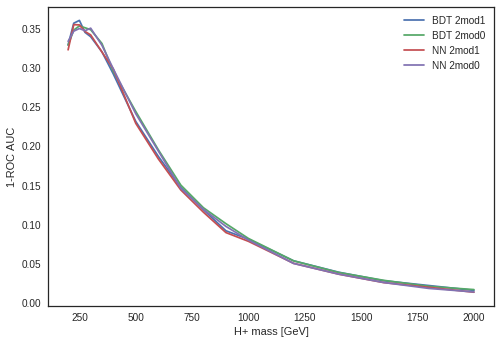

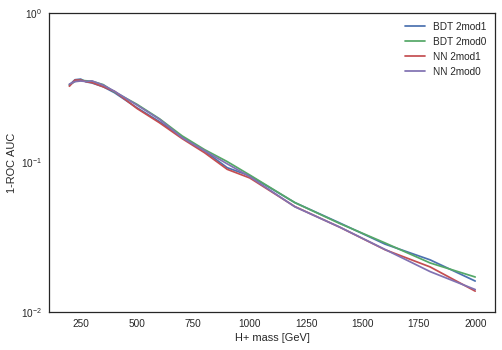

In [67]:
import matplotlib.ticker as ticker

plt.style.use('seaborn-white')

print(bdttrain, bdttest, nntrain, nntest)
plt.plot(hpmasses, bdttest, label="BDT 2mod1")
plt.plot(hpmasses, bdttrain, label="BDT 2mod0")
plt.plot(hpmasses, nntest, label="NN 2mod1")
plt.plot(hpmasses, nntrain, label="NN 2mod0")
plt.ylabel("1-ROC AUC")
plt.xlabel("H+ mass [GeV]")
plt.legend()

fig,ax=plt.subplots()
plt.semilogy(hpmasses, bdttest, label="BDT 2mod1")
plt.semilogy(hpmasses, bdttrain, label="BDT 2mod0")
plt.semilogy(hpmasses, nntest, label="NN 2mod1")
plt.semilogy(hpmasses, nntrain, label="NN 2mod0")
ax.yaxis.set_minor_formatter(ticker.LogFormatter(labelOnlyBase=True))
#ax.yaxis.set_major_formatter(ticker.LogFormatter())
plt.ylim([0.01,1])
plt.ylabel("1-ROC AUC")
plt.xlabel("H+ mass [GeV]")
plt.legend()

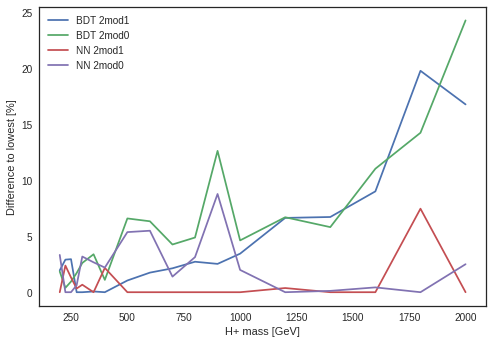

In [68]:
ratiobdttrain=[]
ratiobdttest=[]
rationntrain=[]
rationntest=[]
for i in range(len(hpmasses)):
  mn=min(bdttrain[i],bdttest[i],nntrain[i],nntest[i])
  ratiobdttrain.append((bdttrain[i]-mn)/mn*100)
  ratiobdttest.append((bdttest[i]-mn)/mn*100)
  rationntrain.append((nntrain[i]-mn)/mn*100)
  rationntest.append((nntest[i]-mn)/mn*100)

plt.plot(hpmasses, ratiobdttest, label="BDT 2mod1")
plt.plot(hpmasses, ratiobdttrain, label="BDT 2mod0")
plt.plot(hpmasses, rationntest, label="NN 2mod1")
plt.plot(hpmasses, rationntrain, label="NN 2mod0")
plt.ylabel("Difference to lowest [%]")
plt.xlabel("H+ mass [GeV]")
plt.legend()